In [1]:
import torch
import networkx as nx

In [2]:
edge_index = torch.tensor([[0, 1, 2, 3, 2, 4],
                           [1, 2, 3, 1, 4, 5]], dtype=torch.long)

# only node 0 is an input edge
# (E, 1)
input_mask = torch.tensor([True, False, False, False, False, False])

# only node 3 is an output node 
# (E,1)
# this describes which edges are "output" edges 
# NOTE: we assme outputs are unique, e.g., two different output edges don't describe the same output
output_mask = torch.tensor([False, False, False, False, False, True])

# shape (B, E)
x0 =  torch.tensor([[1., 0., 0., 0.,0.,0.],
                    [-1., 0., 0., 0.,0.,0.]]) 

# 

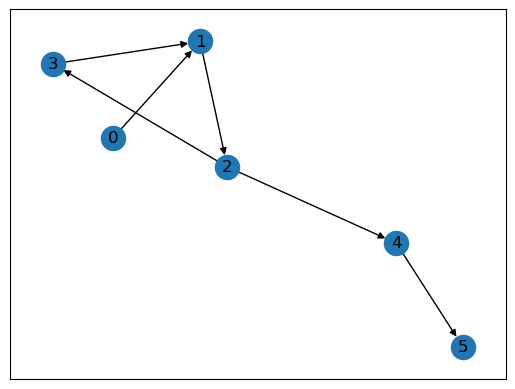

In [3]:
E = (E.detach().cpu().numpy().tolist() for E in edge_index.T)
G = nx.DiGraph(E)


nx.draw_networkx(G)

In [4]:
def get_degree(edge_index, idx): 
    src,dst = edge_index 
    
    out_degree = (src == idx).sum()
    in_degree = (dst == idx).sum()

    return in_degree, out_degree

In [5]:
def get_in_out_ixs(edge_index, idx): 
    '''
    Return the edge id (e.g., index of each edge in `edge_index` that corresponds to a given node `idx` inputs/outputs)
    '''
    src,dst = edge_index 
    
    in_ixs = (dst == idx).nonzero().view(-1)
    out_ixs= (src == idx).nonzero().view(-1)

    return in_ixs, out_ixs

In [6]:
def get_children(edge_index, idx): 
    src,dst = edge_index 
    return dst[src == idx]

In [20]:
class Node(torch.nn.Module): 
    def __init__(self, input_channels, output_channels, in_ixs, out_ixs, idx, children, hidden_channels=2, nonlin=torch.nn.ELU, dropout=0., bias=True): 
        super().__init__()

        self.in_ixs = in_ixs
        self.out_ixs = out_ixs
        self.idx = idx
        self.children = children

        self.nn = torch.nn.Sequential(torch.nn.Linear(input_channels, hidden_channels, bias=bias),
                                      nonlin(), 
                                      torch.nn.BatchNorm1d(hidden_channels),
                                      torch.nn.Dropout(dropout),
                                      torch.nn.Linear(hidden_channels, output_channels, bias=bias))
        
    def forward(self, x): 

        x_in = x[:, self.in_ixs] # shape: (B, in_degree)
        x_out = self.nn(x_in) # shape: (B, out_degree)

        # batch the indices
        B = x.size(0)
        indices = (torch.arange(B).unsqueeze(-1), self.out_ixs.unsqueeze(0).repeat(B, 1))

        x = torch.index_put(x, indices=indices, values=x_out)

        return x

In [21]:
class GSNN(torch.nn.Module): 
    def __init__(self, edge_index, input_mask, output_mask, hidden_channels, layers, dropout=0., nonlin=torch.nn.ELU): 
        super().__init__()

        self.edge_index = edge_index 
        self.input_mask = input_mask 
        self.output_mask = output_mask
        self.layers = layers

        self.node_dict = self.build_nodes(edge_index=edge_index, 
                                          input_mask=input_mask, 
                                          output_mask=output_mask, 
                                          hidden_channels=hidden_channels, 
                                          nonlin=nonlin, 
                                          dropout=dropout)
 
    def forward(self, x): 
        
        # get children of "input" edges 
        src,dst = self.edge_index 
        function_evals = dst[self.input_mask]

        for l in range(self.layers): 
            function_evals_new = []
            for idx in function_evals: 
                x = self.node_dict[str(idx.item())](x)

                # get children 
                function_evals_new.append(self.node_dict[str(idx.item())].children)

            function_evals = torch.unique(torch.cat(function_evals_new, dim=-1))
            #remove "output" nodes from function evals (no "node" key); only for prediction output
            function_evals = function_evals[~torch.isin(function_evals, self.output_mask.nonzero())]

        return x


    def build_nodes(self, edge_index, input_mask, output_mask, hidden_channels, nonlin):
        
        # "function" nodes 
        # All nodes except the src in input edges and dst in output edges 
        src, dst = edge_index 
        function_node_ixs = torch.unique(torch.cat((src[~input_mask], dst[~output_mask]), dim=-1))

        node_dict = {}
        for i in function_node_ixs: 
            in_degree, out_degree = get_degree(edge_index, i)
            in_ixs, out_ixs = get_in_out_ixs(edge_index, i)
            children = get_children(edge_index, i)

            node = Node(input_channels=in_degree, 
                        output_channels=out_degree, 
                        in_ixs = in_ixs, 
                        out_ixs = out_ixs,
                        idx = i,
                        children = children, 
                        hidden_channels=hidden_channels,
                        nonlin = nonlin)
            
            node_dict[str(i.item())] = node
        
        return torch.nn.ModuleDict(node_dict)

In [22]:
model = GSNN(edge_index, input_mask, output_mask, hidden_channels=2, layers=6)

In [23]:
optim = torch.optim.Adam(model.parameters())

In [24]:
out = model(x0)
out.shape

torch.Size([2, 6])

In [25]:
out.squeeze()

tensor([[ 1.0000, -1.0238,  0.4622, -0.0254, -0.2522,  0.7570],
        [-1.0000,  1.0238, -0.4622,  0.0254,  0.2522, -0.7570]],
       grad_fn=<SqueezeBackward0>)

In [26]:
optim.zero_grad()
loss = (out**2).mean()
loss.backward()
optim.step()

In [272]:
src, dst = edge_index 
function_nodes = torch.unique(torch.cat((src[~input_mask], dst[~output_mask]), dim=-1))
function_nodes

tensor([1, 2, 3])